In [1]:
import numpy as np
from matplotlib import pyplot as plt
# TODO: add torch

In [2]:
toy_A = np.array([[3,2],[2,6]])
toy_b = np.array([[2],[-8]])

In [3]:
def steepest_descent(A, b, x0, max_iter=int(1e5), tol=1e-5, recompute=None):
    """
    Solving Ax = b or min(0.5xTAx - bTx + c)
    Steepest descent is at orthogonal to the previous one in each iteration.
    Suitable for scipy sparse and numpy dense arrays.
    Using fast iterative update of residual, rounding errors accumulates.

    A: dense or sparse matrix
    b, x0: column vectors
    recompute: number of iterations to recompute the exact residual, infered if not given

    returns:
        x: final x
        r: final residual
        num_iter: number of iterations run
    """
    if recompute is None:
        recompute = np.sqrt(A.shape[0])
    recompute = int(recompute)

    x = x0
    r = b - A@x
    delta = r.T@r
    tolerance = tol**2 * delta # when ||r_i|| <= tol * ||r_0||
    num_iter = max_iter
    for i in range(max_iter):
        q = A@r
        alpha = delta / (r.T@q)
        x = x + alpha *r
        if i % recompute == 0:
            r = b - A@x
        else:
            r = r - alpha*q
        delta = r.T@r

        if delta <= tolerance:
            num_iter = i+1
            break
    return x, r, num_iter

In [4]:
x0 = np.array([[-1],[-2]])
x, r, num = steepest_descent(toy_A, toy_b, x0, tol=1e-9)
print(num, " iterations taken to get result ", x.T, " with residual ", r.T)

30  iterations taken to get result  [[ 2. -2.]]  with residual  [[7.84016407e-09 5.22677546e-09]]


In [5]:
def CG(A, b, x0, max_iter=int(1e5), tol=1e-5, recompute=None):
    """
    Solving Ax = b or min(0.5xTAx - bTx + c)
    Conjugated gradient starts with the first descent direction as d0,
    The rest of the directions are all mutually A-orthogonal and can be built from d0,
    Thus, one direction only need to descend once
    Suitable for scipy sparse and numpy dense arrays.
    Using fast iterative update of residual, rounding errors accumulates.

    A: dense or sparse matrix
    b, x0: column vectors
    recompute: number of iterations to recompute the exact residual, infered if not given

    returns:
        x: final x
        r: final residual
        num_iter: number of iterations run
    """
    if recompute is None:
        recompute = np.sqrt(A.shape[0])
    recompute = int(recompute)

    x = x0
    r = b - A@x
    d = r
    delta_new = r.T@r
    tolerance = tol**2 * delta_new # when ||r_i|| <= tol * ||r_0||
    num_iter = max_iter
    for i in range(max_iter):
        q = A@d
        alpha = delta_new / (d.T@q)
        x = x + alpha * d
        if i % recompute == 0:
            r = b - A@x
        else:
            r = r - alpha*q

        delta_old = delta_new
        delta_new = r.T@r
        beta = delta_new/delta_old
        d = r + beta*d
        
        if delta_new <= tolerance:
            num_iter = i+1
            break
    return x, r, num_iter

In [6]:
x0 = np.array([[-1],[-2]])
x, r, num = CG(toy_A, toy_b, x0, tol=1e-9)
print(num, " iterations taken to get result ", x.T, " with residual ", r.T)

2  iterations taken to get result  [[ 2. -2.]]  with residual  [[0. 0.]]


In [7]:
def diff(f, x):
    return f
def hess(f, x):
    return f

def NCG(f, x0, max_iter, tol=1e-5, NR_max_iter=100, NR_tol=1e-5, recompute=50):
    """
    Non-linear CG for minimizing any continious function.
    """
    x = x0
    k = 0
    r = -diff(f, x)
    d = r
    delta_new = r.T@r
    tolerance = tol**2 * delta_new # when ||r_i|| <= tol * ||r_0||
    num_iter = max_iter
    for i in range(max_iter):
        delta_d = d.T@d
        for j in range(NR_max_iter): # newton-ralph approximation
            denom = d.T@hess(f,x)@d
            assert x != 0, "try a new starting point"
            alpha = -(diff(f, x)@d / denom)
            x += alpha*d
            if alpha**2 * delta_d <= NR_tol:
                break
        r = -diff(f, x)
        delta_old = delta_new
        delta_new = r.T@r
        beta = delta_new/delta_old
        d = r + beta*d
        if k>=recompute or r.T@d <=0: # restart whenever a search direction is computed that is not descent direction
            k = 0
            d = r

        if delta_new <= tolerance:
            num_iter = i+1
            break
        
    return x, r, num_iter
    

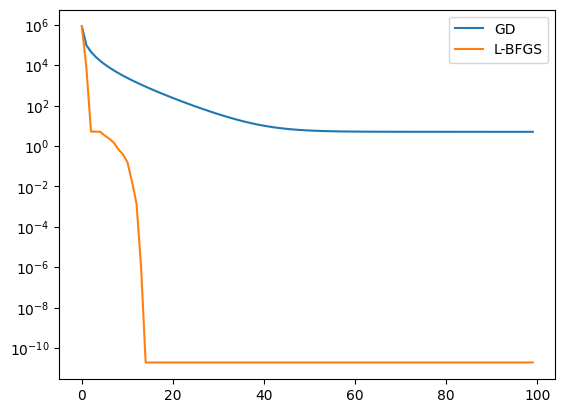

In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt


# 2d Rosenbrock function
def f(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

 
# Gradient descent
x_gd = 10*torch.ones(2, 1)
x_gd.requires_grad = True
gd = optim.SGD([x_gd], lr=1e-5)
history_gd = []
for i in range(100):
    gd.zero_grad()
    objective = f(x_gd)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())


# L-BFGS
def closure():
    lbfgs.zero_grad()
    objective = f(x_lbfgs)
    objective.backward()
    return objective

x_lbfgs = 10*torch.ones(2, 1)
x_lbfgs.requires_grad = True

lbfgs = optim.LBFGS([x_lbfgs],
                    history_size=10, 
                    max_iter=4, 
                    line_search_fn="strong_wolfe")
                    
history_lbfgs = []
for i in range(100):
    history_lbfgs.append(f(x_lbfgs).item())
    lbfgs.step(closure)


# Plotting
plt.semilogy(history_gd, label='GD')
plt.semilogy(history_lbfgs, label='L-BFGS')
plt.legend()
plt.show()